In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pwd
%cd /content/drive/MyDrive/histo

/content/drive/MyDrive/histo


In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, class_labels, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.class_labels = class_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        assert os.path.basename(img_path) == os.path.basename(mask_path), \
            f"Image and mask filenames do not match: {img_path}, {mask_path}"

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        class_label = self.class_labels[idx]

        return image, mask, class_label




In [ ]:
import torchvision.transforms as transforms

# Define a transform with multiple data augmentation techniques
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
])

In [ ]:
import os
from sklearn.model_selection import train_test_split

root_dir = "./EBHI-SEG/"

class_mapping = {
    'Adenocarcinoma': 0,
    'High-grade IN': 1,
    'Low-grade IN': 2,
    'Normal': 3,
    'Polyp': 4,
    'Serrated adenoma': 5
}

categories = class_mapping.keys()

image_paths = []
mask_paths = []
class_labels = []


for category in categories:
    image_dir = os.path.join(root_dir, category, 'image')
    mask_dir = os.path.join(root_dir, category, 'label')


    image_filenames = os.listdir(image_dir)
    mask_filenames = os.listdir(mask_dir)

    for filename in image_filenames:
        if filename in mask_filenames:
            image_paths.append(os.path.join(image_dir, filename))
            mask_paths.append(os.path.join(mask_dir, filename))
            class_labels.append(class_mapping[category])
train_images, val_images, train_masks, val_masks, train_labels, val_labels = train_test_split(
    image_paths, mask_paths, class_labels, test_size=0.2, random_state=42
)


train_dataset = SegmentationDataset(train_images, train_masks, train_labels, transform=transform)
val_dataset = SegmentationDataset(val_images, val_masks, val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)



In [ ]:
'''from collections import Counter

def count_classes(dataset, class_mapping):
    # Extract all class labels from the dataset
    class_labels = [dataset[i][2] for i in range(len(dataset))]  # class labels are at index 2
    class_counts = Counter(class_labels)

    # Print the class counts
    print("Class distribution:")
    for class_idx, count in class_counts.items():
        class_name = list(class_mapping.keys())[list(class_mapping.values()).index(class_idx)]
        print(f"{class_name}: {count} images")

# Count classes in the training set
print("Training Set:")
count_classes(train_dataset, class_mapping)

# Count classes in the validation set
print("\nValidation Set:")
count_classes(val_dataset, class_mapping)'''


'from collections import Counter\n\ndef count_classes(dataset, class_mapping):\n    # Extract all class labels from the dataset\n    class_labels = [dataset[i][2] for i in range(len(dataset))]  # class labels are at index 2\n    class_counts = Counter(class_labels)\n\n    # Print the class counts\n    print("Class distribution:")\n    for class_idx, count in class_counts.items():\n        class_name = list(class_mapping.keys())[list(class_mapping.values()).index(class_idx)]\n        print(f"{class_name}: {count} images")\n\n# Count classes in the training set\nprint("Training Set:")\ncount_classes(train_dataset, class_mapping)\n\n# Count classes in the validation set\nprint("\nValidation Set:")\ncount_classes(val_dataset, class_mapping)'

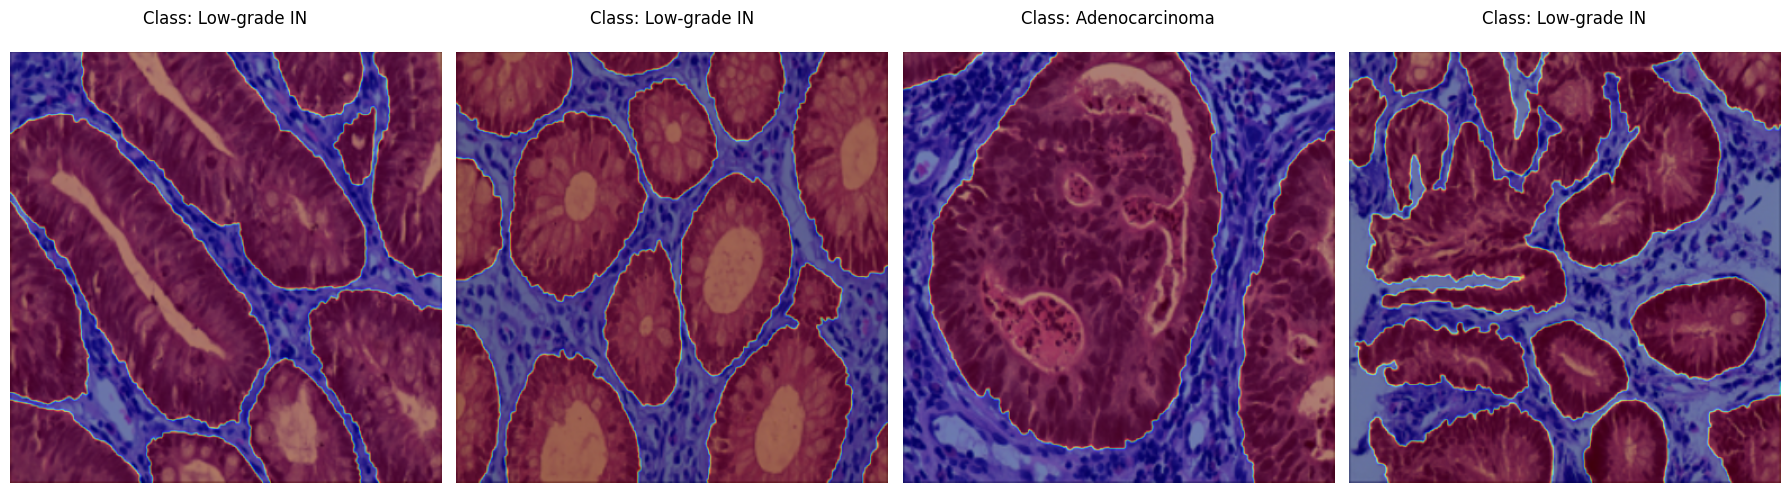

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def visualize_samples(images, masks, labels, class_mapping):

    fig, axs = plt.subplots(1, 4, figsize=(18, 6))
    for i in range(4):
        img = images[i]
        mask = masks[i]
        label = labels[i].item()
        image_np = img.permute(1, 2, 0).numpy()
        image_np = np.clip(image_np, 0, 1)
        mask_np = mask.squeeze().numpy()
        axs[i].imshow(image_np)
        axs[i].imshow(mask_np, cmap='jet', alpha=0.5)
        class_name = list(class_mapping.keys())[list(class_mapping.values()).index(label)]
        axs[i].set_title(f"Class: {class_name}", fontsize=12, pad=20)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

data_iter = iter(train_loader)
images, masks, labels = next(data_iter)

visualize_samples(images, masks, labels, class_mapping)


In [ ]:
import torch
import torch.nn as nn
from segmentation_models_pytorch.base import SegmentationModel
from segmentation_models_pytorch.base import modules as md
from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import SegmentationHead, ClassificationHead
from typing import Optional, Union, List
from segmentation_models_pytorch.decoders.unetplusplus.decoder import UnetPlusPlusDecoder


class UnetPlusPlusWithClassification(SegmentationModel):
    def __init__(
        self,
        encoder_name: str = "resnext50_32x4d",
        encoder_depth: int = 5,
        encoder_weights: Optional[str] = "imagenet",
        decoder_use_batchnorm: bool = True,
        decoder_channels: List[int] = (256, 128, 64, 32, 16),
        decoder_attention_type: Optional[str] = None,
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, callable]] = None,
        aux_params: Optional[dict] = None,
        classification_classes: int = 6
    ):
        super().__init__()

        # Initialize the encoder with a pretrained backbone
        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
        )

        # Initialize the Unet++ decoder
        self.decoder = UnetPlusPlusDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            center=True if encoder_name.startswith("vgg") else False,
            attention_type=decoder_attention_type,
        )

        # Segmentation head (output from the decoder)
        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=classes,
            activation='sigmoid',
            kernel_size=3,
        )

        # Classification head (output from the encoder for 6-class classification)
        self.classification_head = ClassificationHead(
            in_channels=self.encoder.out_channels[-1],
            classes=classification_classes,
            pooling="avg",
            dropout=0.3,
            activation=None,  # CrossEntropyLoss will apply LogSoftmax internally
        )

        self.name = "unet++-{}".format(encoder_name)
        self.initialize()

    def forward(self, x):
        features = self.encoder(x)
        decoder_output = self.decoder(*features)
        masks = self.segmentation_head(decoder_output)
        classification_output = self.classification_head(features[-1])

        return masks, classification_output

In [ ]:
if __name__ == "__main__":
    with torch.no_grad():
        model = UnetPlusPlusWithClassification()
        x = torch.randn(1, 3, 384, 384)
        out3, out4 = model(x)
        print(out3.shape, out4.shape)


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 295MB/s]


torch.Size([1, 1, 384, 384]) torch.Size([1, 6])


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 21.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
from segmentation_models_pytorch.losses import DiceLoss

def dice_coefficient(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()  # Binarize the predictions
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def accuracy(pred, target):
    return (pred.argmax(dim=1) == target).float().mean()

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta
        self.best_model_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_weights = model.state_dict()  # Save best weights
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_weights = model.state_dict()  # Save best weights
            self.counter = 0

def train_model(model, train_loader, val_loader, num_epochs=20, patience=5, device='cpu'):
    model = model.to(device)

    seg_bce_criterion = nn.BCELoss()  # Binary Cross Entropy for segmentation
    seg_dice_criterion = DiceLoss(mode='binary') # Dice Loss for segmentation
    class_criterion = nn.CrossEntropyLoss()  # Cross Entropy for classification

    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        running_seg_loss = 0.0
        running_class_loss = 0.0
        total_dice = 0.0
        total_accuracy = 0.0

        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for images, masks, class_labels in train_loader_tqdm:
            images = images.to(device)
            masks = masks.to(device)
            class_labels = class_labels.to(device)

            seg_output, class_output = model(images)

            seg_bce_loss = seg_bce_criterion(seg_output, masks)
            seg_dice_loss = seg_dice_criterion(seg_output, masks)
            seg_loss = seg_bce_loss + seg_dice_loss  # Combined segmentation loss

            class_loss = class_criterion(class_output, class_labels)
            total_loss = seg_loss + class_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()
            running_seg_loss += seg_loss.item()
            running_class_loss += class_loss.item()

            # Compute Dice coefficient
            total_dice += dice_coefficient(seg_output, masks).item()
            # Compute accuracy
            total_accuracy += accuracy(class_output, class_labels).item()

            train_loader_tqdm.set_postfix(
                Total_Loss=running_loss / len(train_loader),
                Seg_Loss=running_seg_loss / len(train_loader),
                Class_Loss=running_class_loss / len(train_loader),
                Dice_Coeff=total_dice / (train_loader_tqdm.n + 1),
                Accuracy=total_accuracy / (train_loader_tqdm.n + 1)
            )

        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.2f}s, "
              f"Total Loss: {running_loss / len(train_loader):.4f}, "
              f"Segmentation Loss: {running_seg_loss / len(train_loader):.4f}, "
              f"Classification Loss: {running_class_loss / len(train_loader):.4f}, "
              f"Average Dice: {total_dice / len(train_loader):.4f}, "
              f"Average Accuracy: {total_accuracy / len(train_loader):.4f}")

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_seg_loss = 0.0
        val_class_loss = 0.0
        val_dice = 0.0
        val_accuracy = 0.0

        with torch.no_grad():
            val_loader_tqdm = tqdm(val_loader, desc="Validating", leave=False)

            for images, masks, class_labels in val_loader_tqdm:
                images = images.to(device)
                masks = masks.to(device)
                class_labels = class_labels.to(device)

                seg_output, class_output = model(images)

                seg_bce_loss = seg_bce_criterion(seg_output, masks)
                seg_dice_loss = seg_dice_criterion(seg_output, masks)
                seg_loss = seg_bce_loss + seg_dice_loss

                class_loss = class_criterion(class_output, class_labels)
                total_loss = seg_loss + class_loss

                val_loss += total_loss.item()
                val_seg_loss += seg_loss.item()
                val_class_loss += class_loss.item()

                # Compute Dice coefficient
                val_dice += dice_coefficient(seg_output, masks).item()
                # Compute accuracy
                val_accuracy += accuracy(class_output, class_labels).item()

            print(f"Validation Loss: {val_loss / len(val_loader):.4f}, "
                  f"Segmentation Loss: {val_seg_loss / len(val_loader):.4f}, "
                  f"Classification Loss: {val_class_loss / len(val_loader):.4f}, "
                  f"Average Dice: {val_dice / len(val_loader):.4f}, "
                  f"Average Accuracy: {val_accuracy / len(val_loader):.4f}")

        early_stopping(val_loss / len(val_loader), model)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    torch.save(early_stopping.best_model_weights, 'best_unetpp_model.pth')
    print("Best model saved as 'best_unetpp_model.pth'")


In [ ]:
"""import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
from segmentation_models_pytorch.losses import DiceLoss

def train_model(model, train_loader, val_loader, num_epochs=20, patience=5, device='cpu'):
    model = model.to(device)

    # Initialize Dice loss
    seg_dice_criterion = DiceLoss(mode='binary')  # Dice Loss for segmentation
    class_criterion = nn.CrossEntropyLoss()  # Cross Entropy for classification

    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        running_seg_loss = 0.0
        running_class_loss = 0.0
        total_dice = 0.0
        total_accuracy = 0.0

        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for images, masks, class_labels in train_loader_tqdm:
            images = images.to(device)
            masks = masks.to(device)
            class_labels = class_labels.to(device)

            seg_output, class_output = model(images)

            # Use only Dice loss for segmentation
            seg_loss = seg_dice_criterion(seg_output, masks)

            class_loss = class_criterion(class_output, class_labels)
            total_loss = seg_loss + class_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()
            running_seg_loss += seg_loss.item()
            running_class_loss += class_loss.item()

            # Compute Dice coefficient
            total_dice += dice_coefficient(seg_output, masks).item()
            # Compute accuracy
            total_accuracy += accuracy(class_output, class_labels).item()

            train_loader_tqdm.set_postfix(
                Total_Loss=running_loss / len(train_loader),
                Seg_Loss=running_seg_loss / len(train_loader),
                Class_Loss=running_class_loss / len(train_loader),
                Dice_Coeff=total_dice / (train_loader_tqdm.n + 1),
                Accuracy=total_accuracy / (train_loader_tqdm.n + 1)
            )

        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.2f}s, "
              f"Total Loss: {running_loss / len(train_loader):.4f}, "
              f"Segmentation Loss: {running_seg_loss / len(train_loader):.4f}, "
              f"Classification Loss: {running_class_loss / len(train_loader):.4f}, "
              f"Average Dice: {total_dice / len(train_loader):.4f}, "
              f"Average Accuracy: {total_accuracy / len(train_loader):.4f}")

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_seg_loss = 0.0
        val_class_loss = 0.0
        val_dice = 0.0
        val_accuracy = 0.0

        with torch.no_grad():
            val_loader_tqdm = tqdm(val_loader, desc="Validating", leave=False)

            for images, masks, class_labels in val_loader_tqdm:
                images = images.to(device)
                masks = masks.to(device)
                class_labels = class_labels.to(device)

                seg_output, class_output = model(images)

                # Use only Dice loss for validation
                seg_loss = seg_dice_criterion(seg_output, masks)

                class_loss = class_criterion(class_output, class_labels)
                total_loss = seg_loss + class_loss

                val_loss += total_loss.item()
                val_seg_loss += seg_loss.item()
                val_class_loss += class_loss.item()

                # Compute Dice coefficient
                val_dice += dice_coefficient(seg_output, masks).item()
                # Compute accuracy
                val_accuracy += accuracy(class_output, class_labels).item()

            print(f"Validation Loss: {val_loss / len(val_loader):.4f}, "
                  f"Segmentation Loss: {val_seg_loss / len(val_loader):.4f}, "
                  f"Classification Loss: {val_class_loss / len(val_loader):.4f}, "
                  f"Average Dice: {val_dice / len(val_loader):.4f}, "
                  f"Average Accuracy: {val_accuracy / len(val_loader):.4f}")

        # Early stopping check
        early_stopping(val_loss / len(val_loader), model)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    # Save the best model after training
    torch.save(early_stopping.best_model_weights, 'best_unetpp_model.pth')
    print("Best model saved as 'best_unetpp_model.pth'")"""


'import torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom tqdm import tqdm\nimport time\nfrom segmentation_models_pytorch.losses import DiceLoss\n\ndef train_model(model, train_loader, val_loader, num_epochs=20, patience=5, device=\'cpu\'):\n    model = model.to(device)\n\n    # Initialize Dice loss\n    seg_dice_criterion = DiceLoss(mode=\'binary\')  # Dice Loss for segmentation\n    class_criterion = nn.CrossEntropyLoss()  # Cross Entropy for classification\n\n    optimizer = optim.Adam(model.parameters(), lr=1e-4)\n\n    early_stopping = EarlyStopping(patience=patience, verbose=True)\n\n    for epoch in range(num_epochs):\n        start_time = time.time()\n        model.train()\n        running_loss = 0.0\n        running_seg_loss = 0.0\n        running_class_loss = 0.0\n        total_dice = 0.0\n        total_accuracy = 0.0\n\n        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)\n\n        for images, masks, class_labels in

In [ ]:
'''device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model, train_loader, val_loader, num_epochs=100, patience=15, device=device)'''

"device = 'cuda' if torch.cuda.is_available() else 'cpu'\ntrain_model(model, train_loader, val_loader, num_epochs=100, patience=15, device=device)"

In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
saved_model_path = 'best_unetpp_model.pth'
model.load_state_dict(torch.load(saved_model_path))

model.to(device)


model.eval()


<ipython-input-18-56939229714c>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(saved_model_path))


UnetPlusPlusWithClassification(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=Tru

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def predict_and_visualize(model, dataloader, class_mapping, device='cpu', num_samples=4):
    model.eval()
    data_iter = iter(dataloader)

    with torch.no_grad():
        images, masks, labels = next(data_iter)

        images = images.to(device)
        masks = masks.to(device)

        predicted_masks, _ = model(images)

        predicted_masks = (predicted_masks > 0.5).float()

        images = images.cpu()
        masks = masks.cpu()
        predicted_masks = predicted_masks.cpu()

        fig, axs = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))

        for i in range(num_samples):
            img = images[i].permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
            true_mask = masks[i].squeeze().numpy()
            predicted_mask = predicted_masks[i].squeeze().numpy()


            axs[i, 0].imshow(img)
            axs[i, 0].set_title("Original Image", fontsize=15)
            axs[i, 0].axis('off')


            axs[i, 1].imshow(true_mask, cmap='gray')
            axs[i, 1].set_title("Actual Mask", fontsize=15)
            axs[i, 1].axis('off')


            axs[i, 2].imshow(predicted_mask, cmap='gray')
            axs[i, 2].set_title("Predicted Mask", fontsize=15)
            axs[i, 2].axis('off')

        plt.tight_layout()
        plt.show()


predict_and_visualize(model, val_loader, class_mapping, device=device, num_samples=5)


Output hidden; open in https://colab.research.google.com to view.

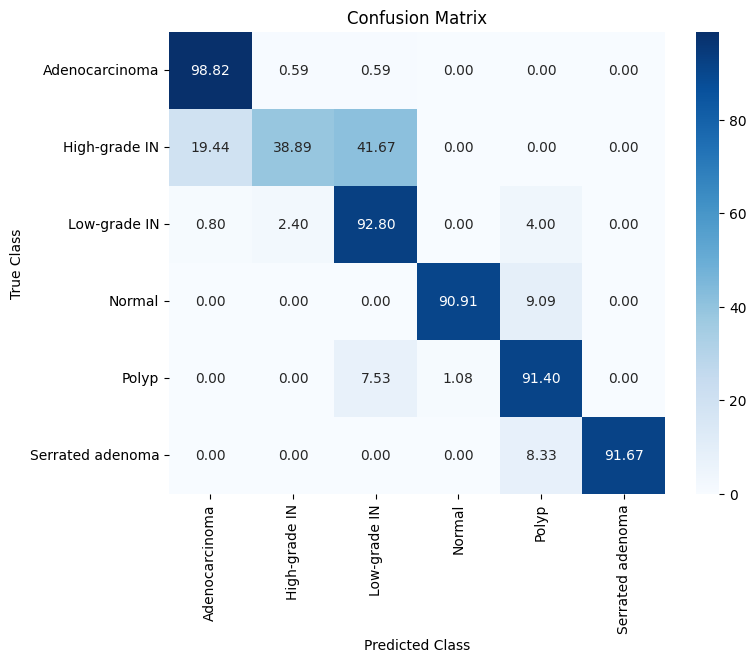

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def generate_confusion_matrix(model, dataloader, class_mapping, device='cpu'):
    model.eval()

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, _, class_labels in dataloader:
            images = images.to(device)
            class_labels = class_labels.to(device)

            _, class_output = model(images)
            preds = class_output.argmax(dim=1)

            true_labels.extend(class_labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    class_names = list(class_mapping.keys())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.show()

    return cm_percentage

cm_percentage = generate_confusion_matrix(model, val_loader, class_mapping, device=device)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def predict_and_visualize_classification(model, dataloader, class_mapping, device='cpu', num_samples=4):
    model.eval()
    data_iter = iter(dataloader)


    index_to_class = {v: k for k, v in class_mapping.items()}

    with torch.no_grad():
        images, masks, labels = next(data_iter)

        images = images.to(device)
        labels = labels.to(device)


        _, class_outputs = model(images)

        predicted_labels = class_outputs.argmax(dim=1)

        images = images.cpu()
        labels = labels.cpu()
        predicted_labels = predicted_labels.cpu()

        fig, axs = plt.subplots(num_samples, 1, figsize=(10, num_samples * 5))

        for i in range(num_samples):
            img = images[i].permute(1, 2, 0).numpy()  # Permute the image dimensions to (H, W, C)
            img = np.clip(img, 0, 1)

            true_label = labels[i].item()
            predicted_label = predicted_labels[i].item()

            true_class_name = index_to_class[true_label]
            predicted_class_name = index_to_class[predicted_label]

            axs[i].imshow(img)
            axs[i].set_title(f"Actual: {true_class_name} | Predicted: {predicted_class_name}", fontsize=15)
            axs[i].axis('off')

        plt.tight_layout()
        plt.show()

predict_and_visualize_classification(model, val_loader, class_mapping, device=device, num_samples=4)


Output hidden; open in https://colab.research.google.com to view.

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_segmentation_with_classification(model, dataloader, class_mapping, device='cpu', num_samples=4):
    """
    Visualizes original images with true labels and masked predictions with predicted labels.
    The mask area is kept visible while the rest of the image is darkened.

    Args:
        model: The trained model.
        dataloader: PyTorch DataLoader for validation/testing.
        class_mapping: Dictionary mapping class indices to class names.
        device: Device to run inference ('cpu' or 'cuda').
        num_samples: Number of samples to visualize.
    """
    model.eval()
    index_to_class = {v: k for k, v in class_mapping.items()}  # Reverse mapping

    try:
        data_iter = iter(dataloader)
        images, masks, labels = next(data_iter)  # Get a batch
    except StopIteration:
        print("No more data in the DataLoader.")
        return

    num_samples = min(num_samples, images.shape[0])  # Avoid IndexError

    images, masks, labels = images.to(device), masks.to(device), labels.to(device)

    with torch.no_grad():
        predicted_masks, class_outputs = model(images)
        predicted_labels = class_outputs.argmax(dim=1)

    # Move tensors back to CPU for visualization
    images, masks, predicted_masks, labels, predicted_labels = (
        images.cpu(), masks.cpu(), predicted_masks.cpu(), labels.cpu(), predicted_labels.cpu()
    )

    fig, axs = plt.subplots(num_samples, 2, figsize=(12, num_samples * 5))

    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy()  # Convert to HWC format
        img = np.clip(img, 0, 1)  # Normalize for visualization

        true_mask = masks[i].squeeze().numpy()
        predicted_mask = (predicted_masks[i].squeeze().numpy() > 0.5).astype(np.uint8)

        true_label = index_to_class.get(labels[i].item(), "Unknown")
        predicted_label = index_to_class.get(predicted_labels[i].item(), "Unknown")

        # Create a dark background
        dark_img = np.zeros_like(img)

        # Keep only the masked area visible
        masked_img = img * np.expand_dims(predicted_mask, axis=-1)

        # Display Original Image with True Label
        axs[i, 0].imshow(img)
        axs[i, 0].set_title(f"Original: {true_label}", fontsize=15, color="green")
        axs[i, 0].axis('off')

        # Display Masked Image with Predicted Label
        axs[i, 1].imshow(masked_img)
        axs[i, 1].set_title(f"Predicted: {predicted_label}", fontsize=15, color="red")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
visualize_segmentation_with_classification(model, val_loader, class_mapping, device=device, num_samples=10)


Output hidden; open in https://colab.research.google.com to view.